<a href="https://colab.research.google.com/github/gkianfar/TIHM-Dataset-Visualization/blob/main/TIHM_data_visualisation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install joypy

**Clone Github repo and set working directory path**

In [5]:
!git clone https://github.com/gkianfar/TIHM-Dataset-Visualization.git
%cd /content/TIHM-Dataset-Visualization

Cloning into 'TIHM-Dataset-Visualization'...
remote: Enumerating objects: 35, done.
remote: Counting objects: 100% (35/35), done.
remote: Compressing objects: 100% (33/33), done.
remote: Total 35 (delta 11), reused 13 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (35/35), 11.19 MiB | 11.15 MiB/s, done.
Resolving deltas: 100% (11/11), done.
/content/TIHM-Dataset-Visualization


**Load packages**

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from matplotlib import cm
from joypy import joyplot
import matplotlib.patches as mpatches
from collections.abc import Iterable
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
warnings.filterwarnings('ignore')
from matplotlib import cm
from joypy import joyplot
from utils import *

%matplotlib inline
## Set colour palette
ibm_colorblind = ['#648FFF', '#FE6100', '#DC267F', '#785EF0', '#FFB000','#48A9A6']
sns.set_palette(ibm_colorblind)

In [25]:
def concat_slist(slist):
    s = ''
    for vs in slist:
        s+= str(vs)+','
    return s

def correct_col_type(df,col):
    raw_type = str(type(df[col].dtype)).split('.')[-1].split('\'')[0].lower()
    #print(col,raw_type)
    if 'object' in raw_type:
        if 'date' in col or 'timestamp' in col or 'datetime' in col:
            return pd.to_datetime(df[col])
        else:
            return df[col].astype('category')
    else:
        return df[col]


def gen_date_col(df, tcol):
    df['date'] = pd.to_datetime(df[tcol].dt.date)
    return df

def transform_category_to_counts(df,col,keys):
    tmp = df.groupby([col]+ keys).size().to_frame('size').reset_index().pivot_table(values = 'size', columns=col, index=keys)
    tmp = tmp.drop(tmp.index[tmp.values.sum(axis=1)==0],axis=0).reset_index()
    return tmp


def get_personal_df(df,pid):
    if not 'patient_id' in df.columns:
        df = df.reset_index()
    tmp = df.loc[df.patient_id==pid].drop('patient_id',axis=1)

    return tmp



def min_max_perpatient(df,skip=[]):
    for pid in df.patient_id.unique():
        ptmp = df.loc[df.patient_id==pid]
        for c in ptmp.columns:
            if 'int' in str(ptmp[c].dtype) or 'float' in str(ptmp[c].dtype):
                if ptmp[c].notna().sum() > 0 and c not in skip:
                    min_v = np.nanmin(ptmp[c].values)
                    max_v = np.nanmax(ptmp[c].values)
                    if max_v > min_v:
                        df.loc[df.patient_id==pid,c] = (ptmp[c].values-min_v)/(max_v-min_v)
                    elif max_v!=0:
                        df.loc[df.patient_id==pid,c] = 0.5 #only one record
    return df


def gen_summary(df):

  sm = pd.DataFrame(columns=['Value Type','Value Number','Description'])

  for stc in df.columns:
      sm.loc[stc,'Value Type'] = str(type(df[stc].dtype)).split('.')[-1].split('\'')[0].lower()
      if 'categorical' in sm.loc[stc,'Value Type'] or 'object' in sm.loc[stc,'Value Type']:
          vset = set(df[stc].values)
          sm.loc[stc, 'Value Number'] = len(vset)
          dl = len(vset) if 5 > len(vset) else 5
          if 'id' in stc:
              sm.loc[stc,'Description'] = 'hash code'
          else:
              sm.loc[stc,'Description'] = concat_slist(list(vset)[:dl])
      elif 'datetime' in sm.loc[stc,'Value Type'].lower():
          sm.loc[stc,'Description'] = 'from '+ str(df[stc].min()) + ' to ' + str(str(df[stc].max()))
      elif 'float' in sm.loc[stc,'Value Type'] or 'int' in sm.loc[stc,'Value Type']:
          sm.loc[stc,'Description'] = 'min: ' + str(df[stc].min()) + ', max: ' + str(str(df[stc].max()))
      elif 'bool' in sm.loc[stc,'Value Type']:
          sm.loc[stc, 'Value Number'] = 2
          sm.loc[stc,'Description'] = 'True or False'

  return sm

#from .data_utils import *

def save_fig(fname,save_path):
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    plt.savefig(os.path.join(save_path,fname),bbox_inches='tight')

def save_personal_fig(pid,fname,save_path):
    save_path = os.path.join(save_path,pid)
    save_fig(fname,save_path)

def add_personal_label_markers(labels_df,pid,ax,max_v,add_marker=True,marker_color='orchid',
                               add_lgd=True,lgd_loc=[1.01,0.75],min_v=0):

    lbs = labels_df.loc[labels_df.patient_id==pid]
    lmarkers = ['*','s','^','o','P','p','h','D']
    lax, lax_lgd = [], []

    if add_marker:
        for i,l in enumerate(lbs.type.values.categories):
            ltmp = lbs.loc[lbs.type==l]
            if len(ltmp)>0:
                ll = ax.plot(ltmp['date'],[max_v]*len(ltmp),lmarkers[i],color=marker_color)
                lax.append(ll[0])
                lax_lgd.append(l)

    for i in range(len(lbs)):
        ax.plot([lbs.date.values[i],lbs.date.values[i]],[min_v,max_v],'--',color='C7')

    if add_lgd:
        lb_patch = mpatches.Patch(color='orchid')
        lbl_lgd = ax.legend([lb_patch]+lax, ['Alerts']+lax_lgd, loc=lgd_loc,fontsize=9)
        ax.add_artist(lbl_lgd)
        return None, None
    else:
        return lax,lax_lgd


def dsample_xticks(N,m=10):
    gap = N/m
    idx = [int(i*gap) for i in range(m)]
    if N%m>0:
        idx+=[N-1]
    return idx


def draw_day_ridge_plot(day_df,ax=None,xticks=None):
    x_range = np.arange(day_df.shape[0])
    f, axes = joyplot(day_df,kind="values",x_range=x_range,overlap = 0.5, colormap=cm.Blues_r,
                      fade=True,figsize=[10,4],linewidth=0.25,alpha=0.6,ax=ax)

    if xticks is None:
        idx = dsample_xticks(day_df.shape[0],m=10)

        axes[-1].set_xticks(x_range[idx],labels=day_df.index[idx])
    else:
        axes[-1].set_xticks(xticks[0],xticks[1])
    return


def vis_day_counts_ridge_plot(raw_df,col,title,fname,save_path='./figs/',drop_list=None,
                              transform=False,ax=None,xticks=None):
    if transform:
        tmp = raw_df.groupby([col, 'date']).size().to_frame('size').reset_index().pivot_table(values = 'size', columns=col, index='date')
    else:
        tmp = raw_df.groupby('date')[act_df.select_dtypes(include=['number']).columns].sum()

    if drop_list is not None:
        tmp = tmp.drop(drop_list,axis=1)
    draw_day_ridge_plot(tmp,ax=ax,xticks=xticks)
    plt.title(title)
    save_fig(fname,save_path=save_path)


def get_personal_sleep_day_df(sleep_df,pid):

    sleep_states = ['AWAKE', 'LIGHT', 'DEEP', 'REM']
    sleep_df = sleep_df.set_index('date')
    sdtmp = get_personal_df(sleep_df,pid).loc[:,sleep_states]#get_personal_agg_info_df(sleep_df,pid,cols=sleep_states,keys=['date'],agg_fn='sum')
    pdtmp = get_personal_df(sleep_df,pid).loc[:,['heart_rate','respiratory_rate']] #get_personal_agg_info_df(sleep_df,pid,cols=['heart_rate','respiratory_rate'],keys=['date'],agg_fn='max')

    return sdtmp,pdtmp

def vis_personal_aligned_multiview_day_plot(phys_df,pgrps,pid,save_path,sleep_df=None,act_df=None,
                                            labels_df=None,ftype='svg',xticks=None):

    sns.set_style("whitegrid",{'axes.grid': True,'grid.linestyle': '--', 'axes.spines.left':False,
                            'axes.spines.right':False,'axes.spines.top':False})
    cmap = sns.color_palette('colorblind')#cm.get_cmap('tab10').colors

    #sleep_states = sleep_df['state'].unique()
    if sleep_df is not None:
        sdtmp, _ = get_personal_sleep_day_df(sleep_df,pid)
    if act_df is not None:
        adtmp = transform_category_to_counts(act_df,col='location_name',keys=['patient_id','date'])

        adtmp = get_personal_df(adtmp,pid)
        adtmp = adtmp.set_index('date')
        adtmp['total'] = adtmp.sum(axis=1)

    if sleep_df is not None and len(sdtmp) > 0 and act_df is not None:
        adtmp,sdtmp = align_dates(adtmp,sdtmp)



    pdtmp = get_personal_df(phys_df,pid)
    #pdtmp = pdtmp.set_index('date')
    if act_df is not None:
        pdtmp.drop(pdtmp.loc[(pdtmp.date<adtmp.index.values.min())|(pdtmp.date>adtmp.index.values.max())].index,axis=0,inplace=True)
    pv = pd.pivot_table(pdtmp, values='value', index=['date'],
                    columns=['device_type'])
    pv = pv.rename(columns={'Skin Temperature':'Skin temperature','Body Temperature':'Body temperature'})
    pvs = []
    for i,pgrp in enumerate(pgrps.values()):
        pgrp = list(set(pgrp) & set(pv.columns))
        if len(pgrp)>0:
            pvi = pv[pgrp]
            pvi = pvi.drop(pvi.columns[pvi.values.sum(axis=0)==0],axis=1)
            pvs.append(pvi)



    nr = len(pvs)+1 if act_df is not None else len(pvs)
    f, axs = plt.subplots(nr, 1,gridspec_kw={'height_ratios': [1]*nr},figsize=[10,3*nr],sharex=True)

    ci = 0
    axi = 0
    if act_df is not None:
        aax = axs[0].fill_between(x=adtmp.index,y1=np.zeros(adtmp.shape[0]),y2=adtmp['total'].values,alpha=0.4,color=cmap[ci])
        handles = [aax]
        max_v = adtmp.values.max()
        lgd = ['Acitivity counts']
        ci+=1
        if sleep_df is not None and len(sdtmp) > 0:
            sdtmp['total'] = sdtmp.sum(axis=1)
            sax = axs[0].fill_between(x=sdtmp.index,y1=np.zeros(sdtmp.shape[0]),y2=sdtmp['total'].values,alpha=0.4,color=cmap[ci])
            ci+=1
            handles.append(sax)
            max_v = max(max_v,sdtmp.values.max())
            lgd.append('Sleep duration (minutes)')

        axs[0].tick_params(labelbottom=True)
        axi += 1

    if labels_df is not None:
        if act_df is not None:
            labels_df = labels_df.drop(labels_df.loc[(labels_df.date<adtmp.index.values.min())|(labels_df.date>adtmp.index.values.max())].index,axis=0)
        labels_df = labels_df.loc[labels_df['patient_id']==pid]
        if len(labels_df)==0:
            labels_df = None

    if labels_df is not None and axi >0:
        add_personal_label_markers(pid=pid,ax=axs[0],max_v=max_v,
                                   labels_df=labels_df,lgd_loc=[1.01,0.5],add_lgd=True)
        axs[0].legend(handles,lgd,loc=[1.01,0.1])



    for i,pvi in enumerate(pvs):

        lls = axs[i+axi].plot(pvi.index,pvi.values,'.-')
        for l in lls:
            l.set_color(cmap[ci])
            ci+=1

        axs[i+axi].tick_params(labelbottom=True)

        max_v = pvi.fillna(0).values.max()*1.1
        min_v = pvi.fillna(999).values.min()*0.9

        if labels_df is not None:
            if i+axi>0:
                add_personal_label_markers(pid=pid,ax=axs[i+axi],max_v=max_v,
                                       labels_df=labels_df,add_marker=True,add_lgd=False,min_v=min_v)
            else:
                add_personal_label_markers(pid=pid,ax=axs[0],max_v=max_v,
                                   labels_df=labels_df,lgd_loc=[1.01,0.5],add_lgd=True)

        axs[i+axi].legend(pvi.columns,loc=[1.01,0.1])

    if xticks is None:
        if act_df is None:
            xidx = dsample_xticks((pvs[0].index[-1]-pvs[0].index[0]).days,m=8)
            xticks = [pvs[0].index.values[0]+pd.Timedelta(xi,'D') for xi in xidx]
        else:
            xidx = dsample_xticks((adtmp.index[-1]-adtmp.index[0]).days,m=8)
            xticks = [adtmp.index.values[0]+pd.Timedelta(xi,'D') for xi in xidx]
        axs[0].set_xticks(xticks,labels=xticks)

    else:
        axs[0].set_xticks(xticks,labels=xticks)

    #axs[0].set_title('Patient '+str(pid)+' aligned multiview day trend')
    save_personal_fig(pid=pid,fname='personal_multiview_day_plot.'+ftype,save_path=save_path)





**Set Data and Fig folders paths**

In [21]:
## Please change the path with the path of your dataset
DPATH = './Data'
SAVE_PATH = './Figs/'
if not os.path.exists(SAVE_PATH):
    os.makedirs(SAVE_PATH)



**Load and preprocess dataset files**

In [26]:
## Read all tables into data_dict and generate table summaries
files = os.listdir(DPATH)
data_dict = {}
summaries = {}
for f in files:
    if 'csv' not in f:
        continue
    print(f)
    fpth = os.path.join(DPATH,f)
    df = pd.read_csv(fpth)

    for col in df.columns:
        df[col] = correct_col_type(df,col)

    if 'date' in df.columns:
        df = df.rename(columns={'date':'timestamp'})
        df['date'] = pd.to_datetime(df['timestamp'].dt.date)

    fname = f.split('.')[0]
    data_dict[fname] = df
    summaries[fname] = gen_summary(df)

for name, data in data_dict.items():
  print(f'__________________{name} data:\n ________________')
  print(f'{data.head()} \n summary: \n {summaries[name]}')
  print('________________________________________')

Activity.csv
Sleep.csv
Labels.csv
Demographics.csv
Physiology.csv
__________________Activity data:
 ________________
  patient_id location_name           timestamp       date
0      0697d   Fridge Door 2019-06-28 13:03:29 2019-06-28
1      0697d       Kitchen 2019-06-28 13:11:44 2019-06-28
2      0697d    Front Door 2019-06-28 13:13:50 2019-06-28
3      0697d       Bedroom 2019-06-28 13:13:53 2019-06-28
4      0697d   Fridge Door 2019-06-28 13:14:09 2019-06-28 
 summary: 
                      Value Type Value Number  \
patient_id     categoricaldtype           56   
location_name  categoricaldtype            8   
timestamp       datetime64dtype          NaN   
date            datetime64dtype          NaN   

                                                   Description  
patient_id                                           hash code  
location_name   Bedroom,Fridge Door,Front Door,Lounge,Kitchen,  
timestamp      from 2019-04-01 00:05:46 to 2019-06-30 23:59:32  
date           from 2

**Demographics.csv Visualization**

<Axes: title={'center': 'Distribution by Sex'}>

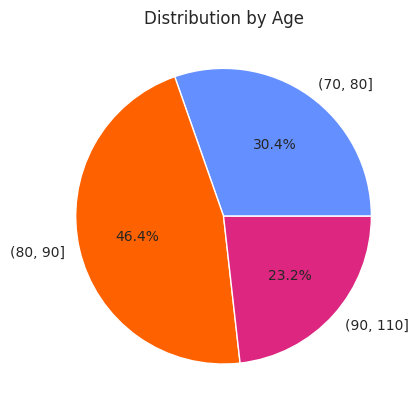

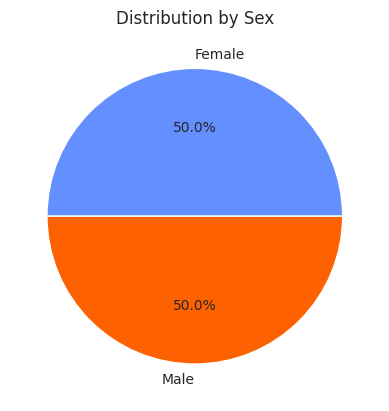

In [15]:
plt.figure()

data_dict['Demographics'].groupby('age')['patient_id'].count().plot.pie(
    ylabel='',
    autopct='%1.1f%%',
    title='Distribution by Age',
)
plt.figure()
data_dict['Demographics'].groupby('sex')['patient_id'].count().plot.pie(
    ylabel='',
    autopct='%1.1f%%',
    title='Distribution by Sex',
)

**Sleep.csv Visualization**

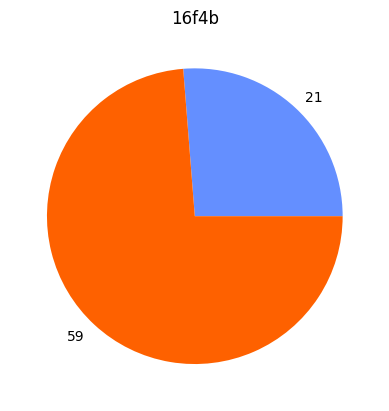

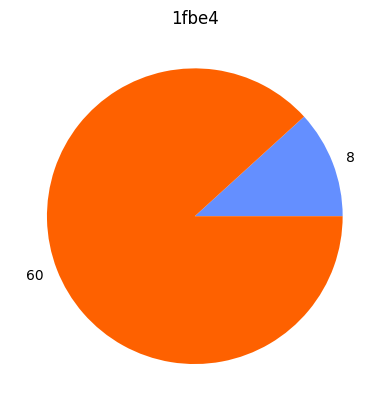

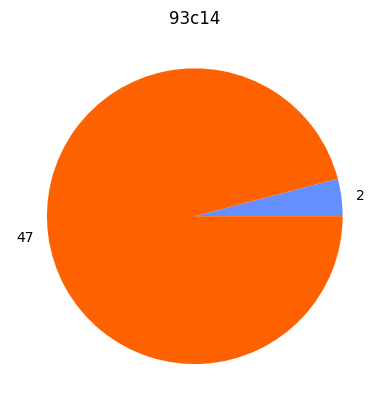

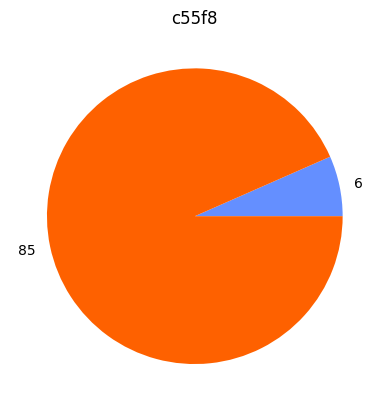

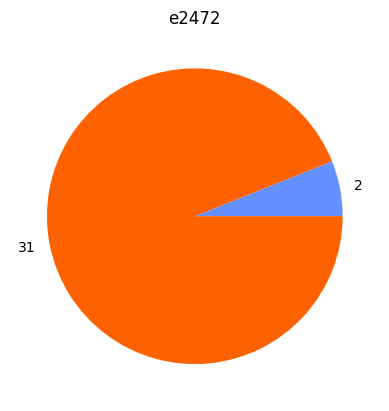

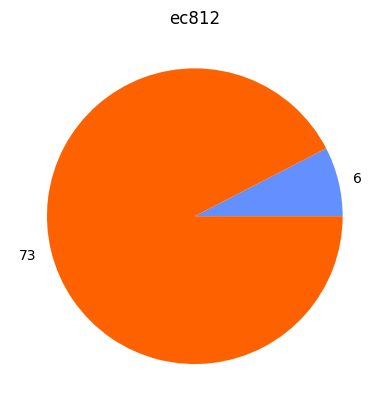

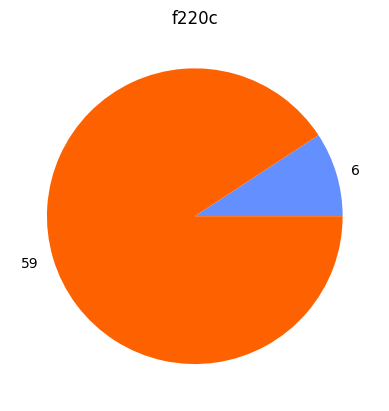

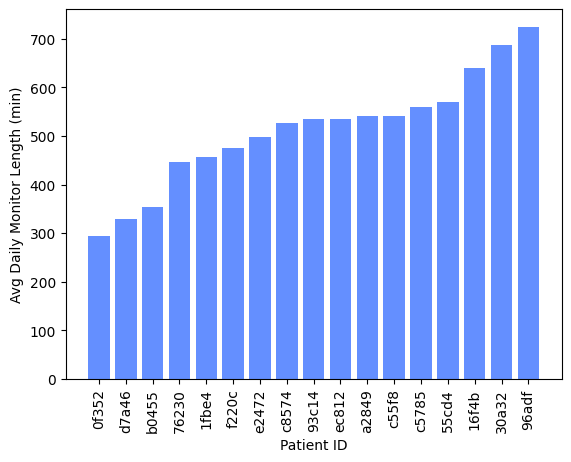

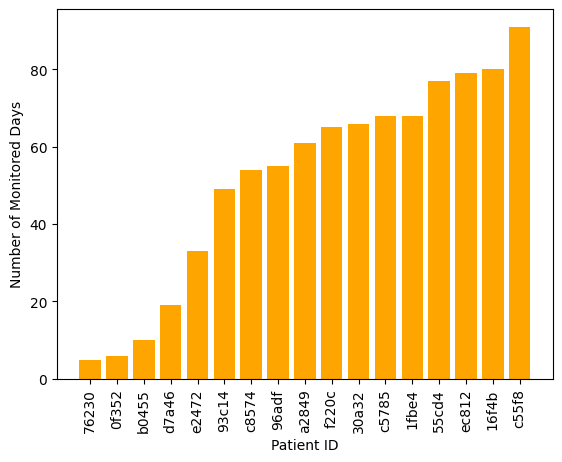

In [ ]:
monitor_avg = {}
dates_missed = {}
dates_monitored = {}

for pid in patients:
  monitor_avg[pid] = missing[pid].monitored.mean()
  dates_missed[pid] = missing[pid].loc[missing[pid]['min'].isna()].index.nunique()
  dates_monitored[pid] = missing[pid].loc[~missing[pid]['min'].isna()].index.nunique()

for pid in patients:
  if dates_missed[pid]>0:
    fig, ax = plt.subplots(1)
    ax.pie([dates_missed[pid],dates_monitored[pid]], labels=[dates_missed[pid],dates_monitored[pid]])
    ax.set_title(f'{pid}')
    fig.savefig(f'{SAVE_PATH}/{pid}_sleep_missing_pie.png')
fig, ax = plt.subplots(1)
sorted_indices = np.argsort(list(monitor_avg.values()))
x = np.array(list(monitor_avg.keys()))[sorted_indices]  # Sorted keys
y = np.array(list(monitor_avg.values()))[sorted_indices]  # Sorted values
ax.bar(x,y)
ax.set_ylabel('Avg Daily Monitor Length (min)')
ax.set_xlabel('Patient ID')
ax.set_xticks(range(len(monitor_avg.keys())),x, rotation='vertical')
fig.savefig(f'{SAVE_PATH}/sleep_daily_monitor.png')

fig, ax = plt.subplots(1)
y = []
x = []

# Populate x and y
for k, v in dates_missed.items():
    y.append(dates_monitored[k] + v)
    x.append(k)

# Convert to NumPy arrays for sorting
y = np.array(y)
x = np.array(x)
sorted_indices = np.argsort(y)
y = y[sorted_indices]
x = x[sorted_indices] # Sorted keys
ax.bar(x,y,color='orange')
ax.set_ylabel('Number of Monitored Days')
ax.set_xlabel('Patient ID')
ax.set_xticks(range(len(x)),x, rotation='vertical')
fig.savefig(f'{SAVE_PATH}/sleep_date_monitor.png')

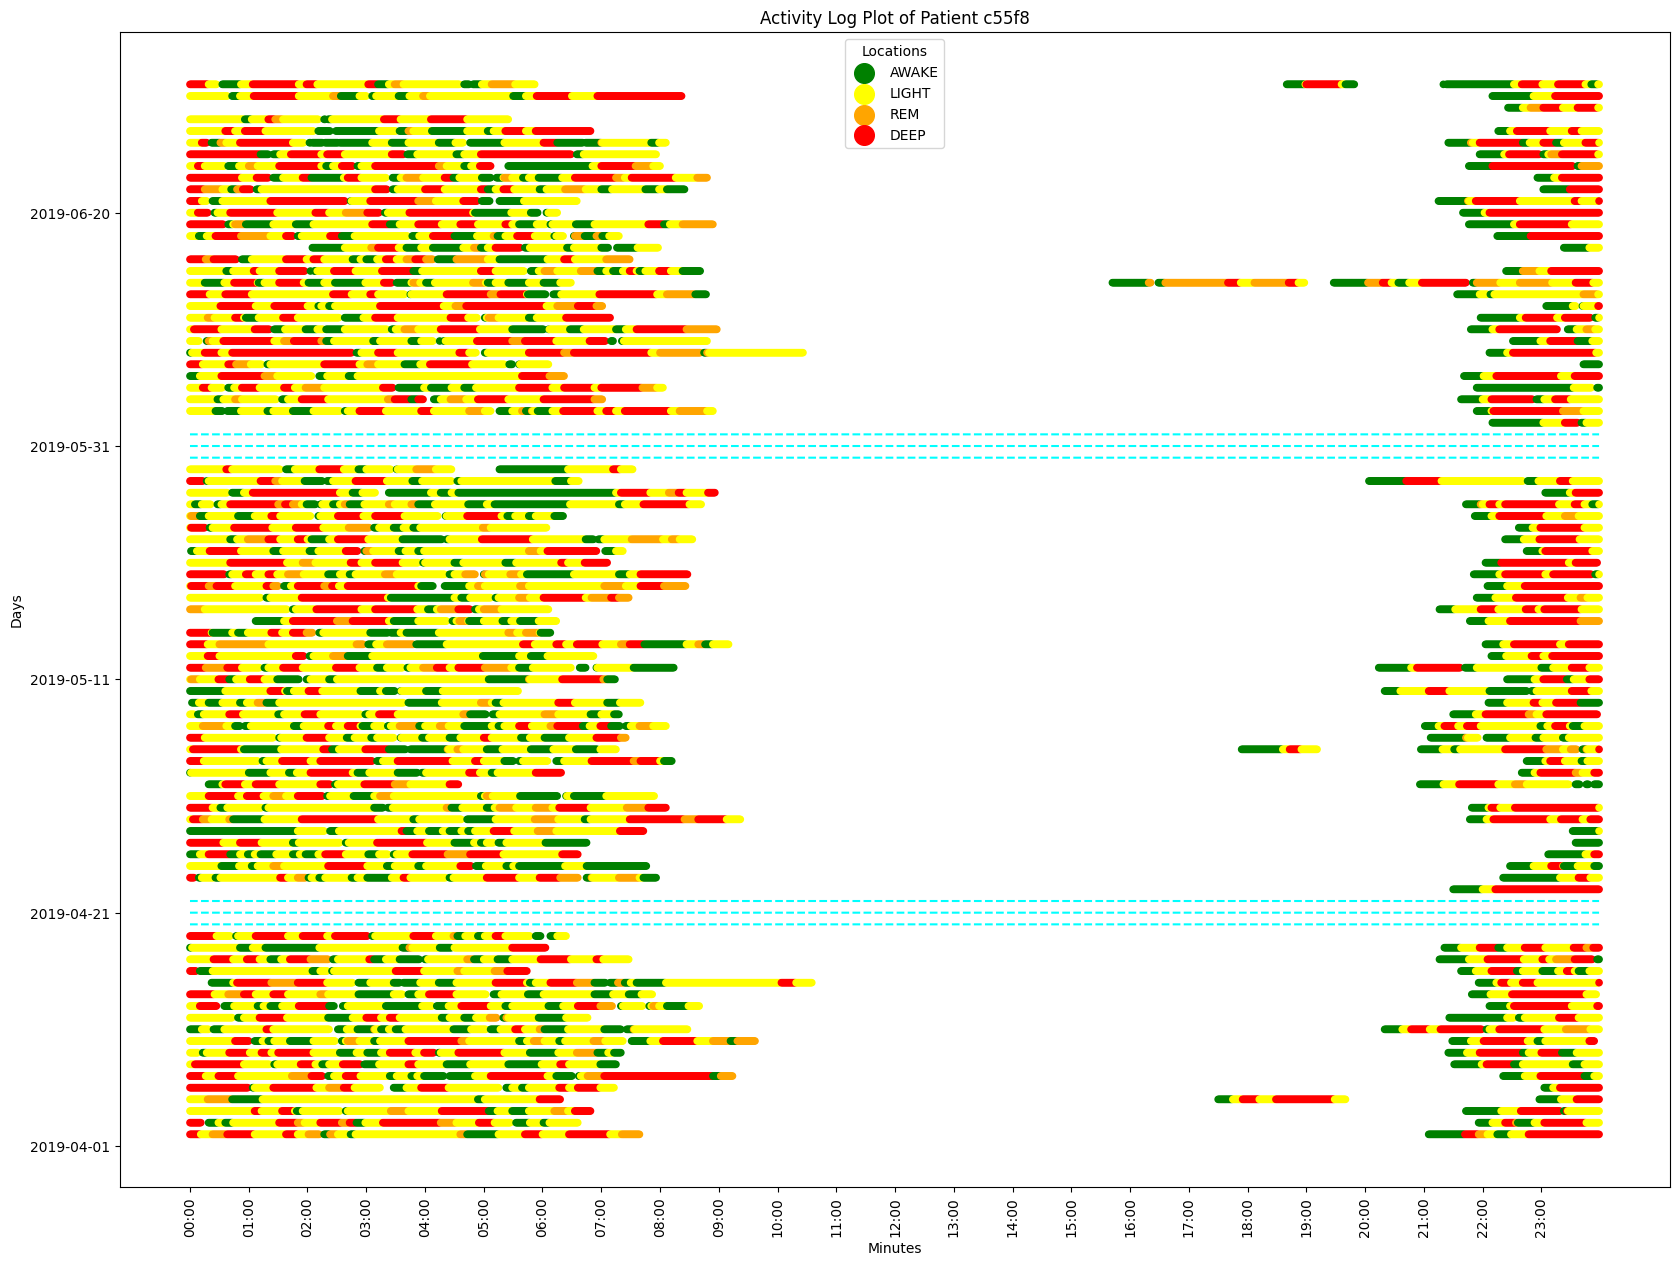

In [ ]:
### SLEEP
def find_missing_dates(timestamp_list):
    # Convert list to pandas DatetimeIndex
    date_index = pd.to_datetime(timestamp_list)

    # Get the range of dates from the first to the last date
    all_dates = pd.date_range(start=date_index.min(), end=date_index.max())

    # Find missing dates
    missing_dates = all_dates.difference(date_index)

    missing_dates = [d.date() for d in missing_dates]
    all_dates = [d.date() for d in all_dates]

    return missing_dates, all_dates


f = 'Sleep.csv'
fpth = os.path.join(DPATH,f)
df = pd.read_csv(fpth)
for col in df.columns:
    df[col] = correct_col_type(df,col)
if 'date' in df.columns:
    df = df.rename(columns={'date':'timestamp'})
sleep_df = gen_date_col(df,tcol='timestamp')
date_min = sleep_df.date.min()
date_max = sleep_df.date.max()
date_period_length = sleep_df.date.nunique()
freq = 20
date_labels = pd.date_range(start=date_min, end=date_max, freq=f'{freq}D').strftime('%Y-%m-%d')

#print(df[670:680])

sleep_patients = np.unique(sleep_df['patient_id'])

pid = 'c55f8'
day_window = 100  # the window of days
df_id = sleep_df.loc[sleep_df['patient_id'] == pid].copy()
date_id = np.unique(df_id['date'])

missing_days, all_dates = find_missing_dates(date_id)

# Mapping dictionary
color_mapping = {
    'AWAKE': 'green',
    'LIGHT': 'yellow',
    'REM': 'orange',
    'DEEP': 'red'
}

# Create a list of time strings in the format HH:MM from 00:00 to 23:59 with a frequency of 1 minute
time_strings = [f"{i:02}:{j:02}" for i in range(24) for j in range(60)]

# Plotting
plt.figure(figsize=(20, 15))  # Increased the figure size for larger plot area
for day in range(min(len(all_dates), day_window)):
    if all_dates[day] in missing_days:
        plt.plot(range(len(time_strings)), [day + 1] * len(time_strings), color='cyan', linestyle='--')
    else:
        state_id = df_id[df_id['date'] == all_dates[day]]['state'].tolist()
        timestamp_id = df_id[df_id['date'] == all_dates[day]]['timestamp'].tolist()

        # Convert the smaller list of Timestamps to "hour:min" format
        small_time_strings = [ts.strftime("%H:%M") for ts in timestamp_id]

        # Find the indices of the elements of the smaller list in the larger list
        indices = [time_strings.index(time) for time in small_time_strings if time in time_strings]

        # Changing the elements in list A according to the mapping
        color_map = [color_mapping[stat] for stat in state_id]

        # Create the scatter plot with larger points
        plt.scatter(indices, [day + 1] * len(color_map), color=color_map, s=20)  # Increased marker size

# Add legends
for loc, color in color_mapping.items():
    plt.scatter([], [], color=color, label=loc, s=200)

# Plot formatting
hours = [f"{i//60:02}:{i%60:02}" for i in range(0, len(time_strings), 60)]
plt.xticks(range(0, len(time_strings), 60), hours, rotation=90)  # Set x-ticks to show every hour
plt.yticks(range(0, date_period_length, freq), date_labels)  # Set x-ticks to show every hour
plt.xlabel('Minutes')
plt.ylabel('Days')
plt.title(f'Activity Log Plot of Patient {pid}')
plt.legend(title='Locations', loc='upper center')  # Adjust legend position
#plt.tight_layout()

plt.show()

In [11]:
patients_activity = data_dict['Activity'].patient_id.unique()
patients_physiology = data_dict['Physiology'].patient_id.unique()
patients_labels = data_dict['Labels'].patient_id.unique()
patients_sleep = data_dict['Sleep'].patient_id.unique()

total_patients = list(set(np.concatenate((patients_activity,
                                  patients_physiology,
                                      patients_labels,
                                         patients_sleep))))
num_total_patients = len(total_patients)
df = pd.DataFrame({'activity':np.zeros(num_total_patients),
                   'physiology':np.zeros(num_total_patients),
                   'labels':np.zeros(num_total_patients),
                   'sleep':np.zeros(num_total_patients)},index=total_patients)
for p in total_patients:
  df.loc[p,"activity"] = 1 if p in patients_activity else 0
  df.loc[p,"physiology"] = 1 if p in patients_physiology else 0
  df.loc[p,"labels"] = 1 if p in patients_physiology else 0
  df.loc[p,"sleep"] = 1 if p in patients_sleep else 0
df

,activity,physiology,labels,sleep
f220c,1.0,1.0,1.0,1.0
7db78,1.0,1.0,1.0,0.0
a539e,1.0,1.0,1.0,0.0
ab47a,1.0,1.0,1.0,0.0
ca44d,1.0,1.0,1.0,0.0
e87bd,1.0,1.0,1.0,0.0
b0455,1.0,1.0,1.0,1.0
c8574,1.0,1.0,1.0,1.0
e4959,1.0,1.0,1.0,0.0
b9d58,1.0,1.0,1.0,0.0


**Activity.csv Visualization**

Text(0, 0.5, 'Number of Paticipants')

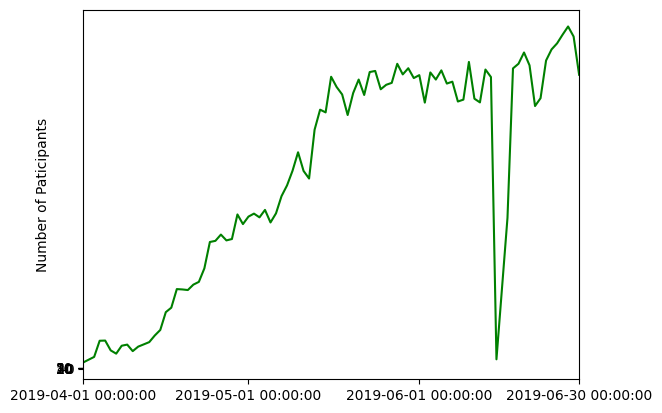

In [12]:
## Visualise number of paticipants with time
p_ct=data_dict['Activity'].groupby('date').agg(size=('patient_id','size'))
plt.figure()
plt.plot(p_ct,color='g')
idx = [0,29,60,88]
plt.xticks(p_ct.index[idx],labels=p_ct.index[idx])

plt.xlim(p_ct.index[0],p_ct.index[-1])
plt.yticks(np.arange(0,60,10))
plt.ylabel('Number of Paticipants')

**Physiology.csv Visualization**

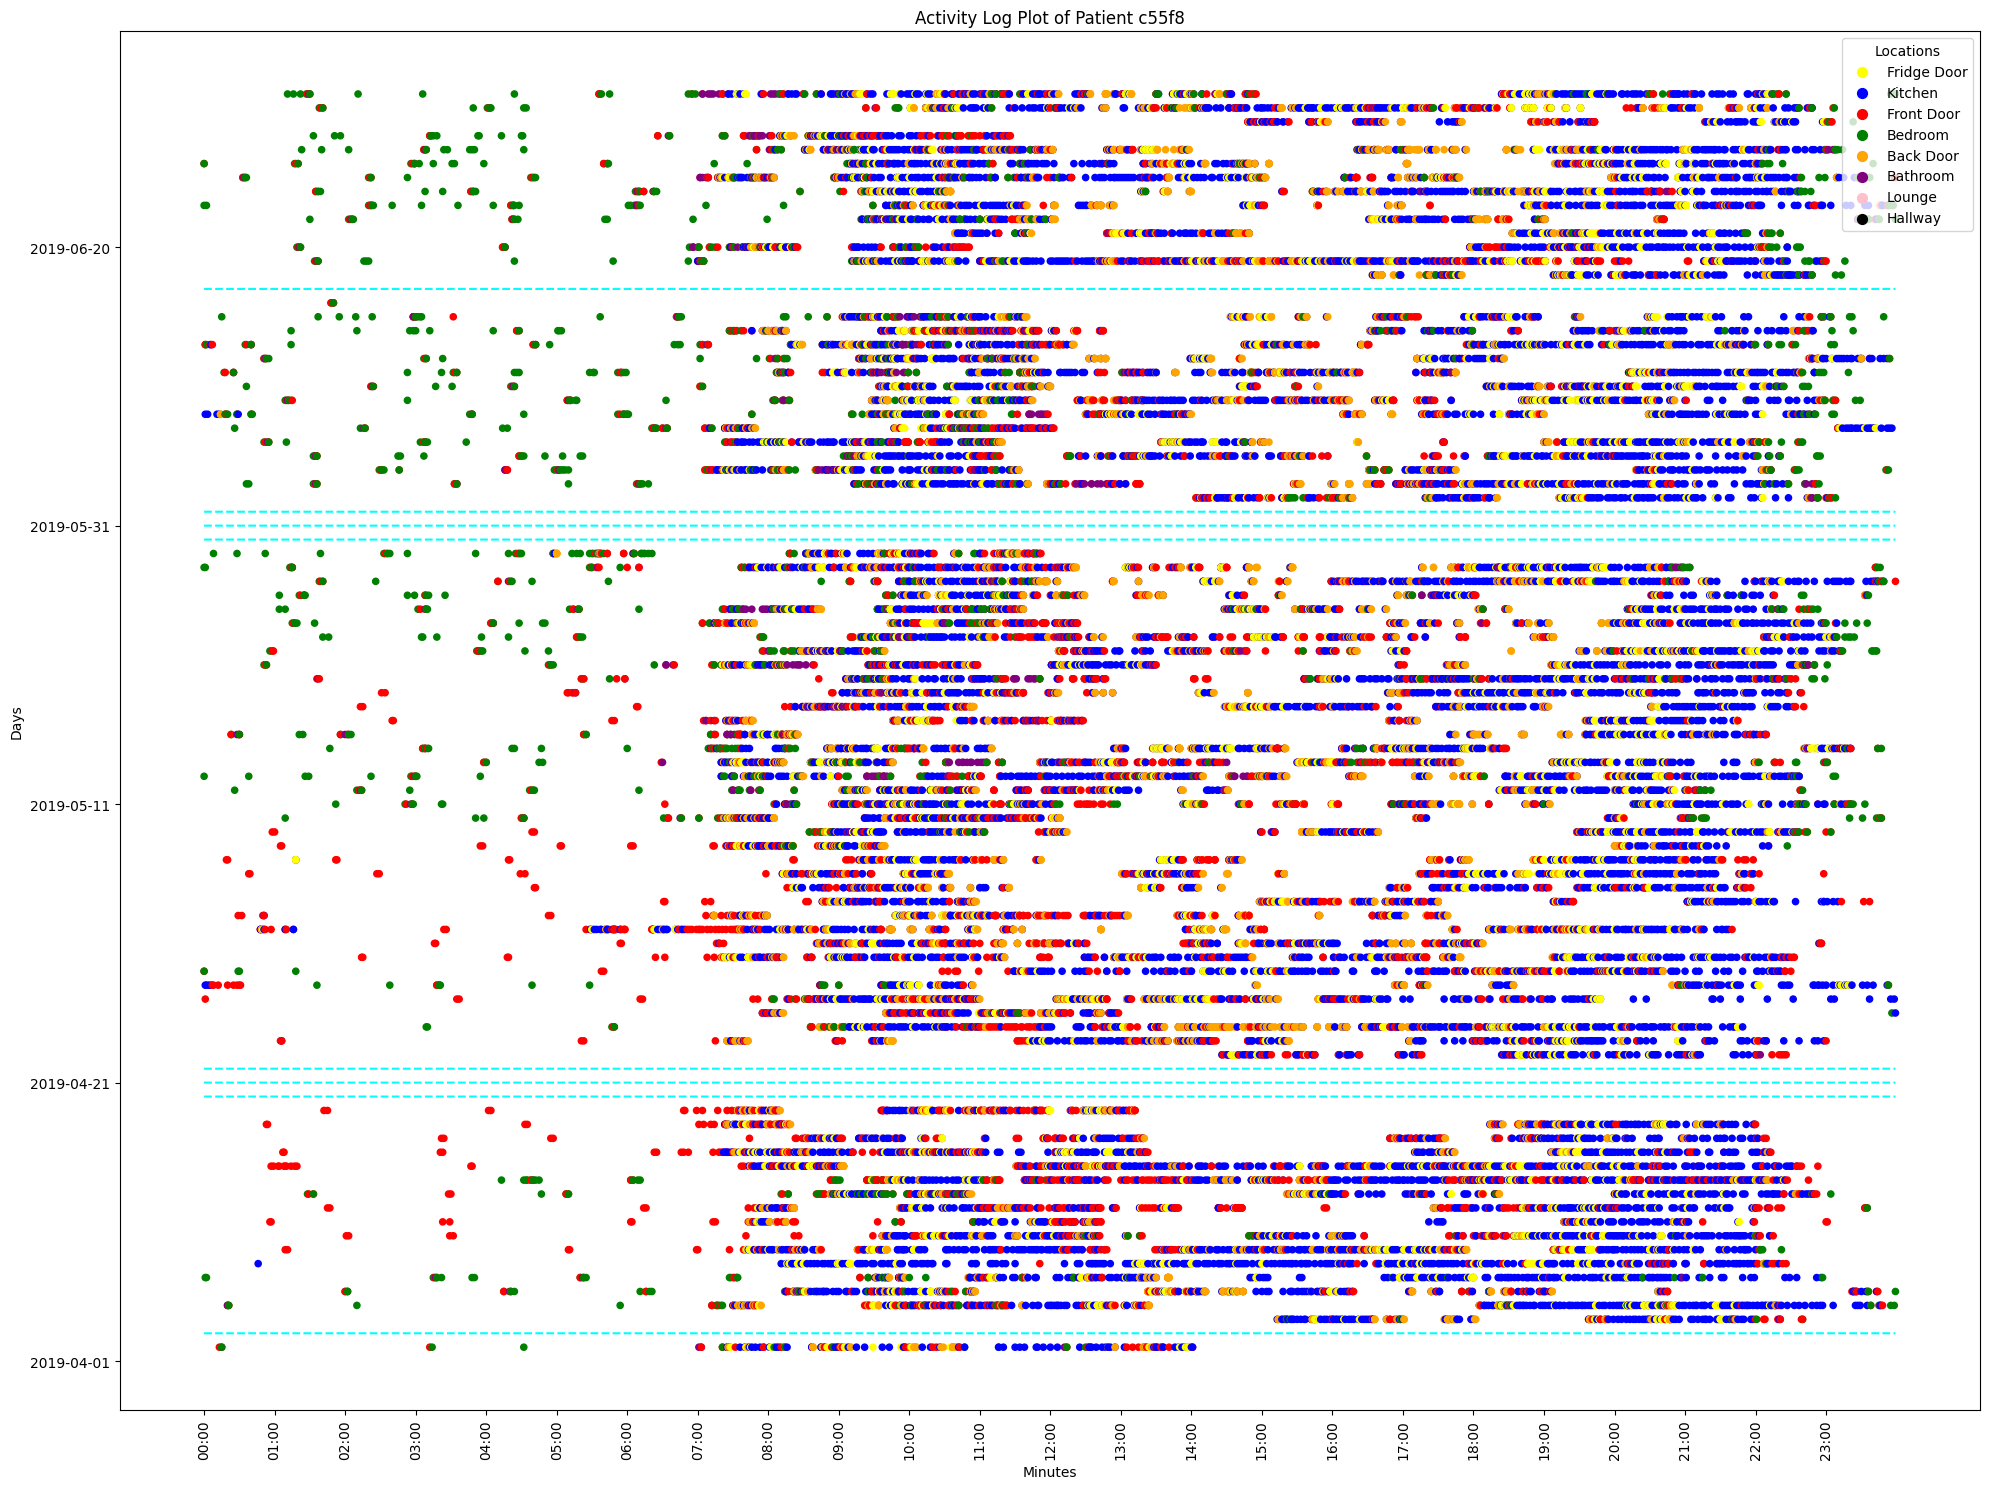

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

def find_missing_dates(timestamp_list):
    # Convert list to pandas DatetimeIndex
    date_index = pd.to_datetime(timestamp_list)

    # Get the range of dates from the first to the last date
    all_dates = pd.date_range(start=date_index.min(), end=date_index.max())

    # Find missing dates
    missing_dates = all_dates.difference(date_index)

    missing_dates = [d.date() for d in missing_dates]
    all_dates = [d.date() for d in all_dates]

    return missing_dates, all_dates

# File paths and data loading
DPATH = '/content/TIHM/Dataset'
f = 'Activity.csv'
fpth = os.path.join(DPATH, f)
df = pd.read_csv(fpth)

for col in df.columns:
    df[col] = correct_col_type(df, col)

if 'date' in df.columns:
    df = df.rename(columns={'date': 'timestamp'})

activity_df = gen_date_col(df, tcol='timestamp')

activity_patients = np.unique(df['patient_id'])
date_min = activity_df.date.min()
date_max = activity_df.date.max()
date_period_length = activity_df.date.nunique()
freq = 20
date_labels = pd.date_range(start=date_min, end=date_max, freq=f'{freq}D').strftime('%Y-%m-%d')

# Parameters
pid = 'c55f8'  # patient_id
day_window = 100  # the window of days
df_id = activity_df.loc[activity_df['patient_id'] == pid].copy()
date_id = np.unique(df_id['date'])
missing_days, all_dates = find_missing_dates(date_id)
# Mapping dictionary
color_mapping = {
    'Fridge Door': 'yellow',
    'Kitchen': 'blue',
    'Front Door': 'red',
    'Bedroom': 'green',
    'Back Door': 'orange',
    'Bathroom': 'purple',
    'Lounge': 'pink',
    'Hallway': 'black'
}

# Create a list of time strings in the format HH:MM from 00:00 to 23:59 with a frequency of 1 minute
time_strings = [f"{i:02}:{j:02}" for i in range(24) for j in range(60)]

# Plotting
fig, ax = plt.subplots(figsize=(20, 15))  # Increased the figure size for larger plot area
for day in range(min(len(all_dates), day_window)):
    if all_dates[day] in missing_days:
        plt.plot(range(len(time_strings)), [day + 1] * len(time_strings), color='cyan', linestyle='--')
    else:
        location_id = df_id[df_id['date'] == all_dates[day]]['location_name'].tolist()
        timestamp_id = df_id[df_id['date'] == all_dates[day]]['timestamp'].tolist()

        # Convert the smaller list of Timestamps to "hour:min" format
        small_time_strings = [ts.strftime("%H:%M") for ts in timestamp_id]

        # Find the indices of the elements of the smaller list in the larger list
        indices = [time_strings.index(time) for time in small_time_strings if time in time_strings]

        # Changing the elements in list A according to the mapping
        color_map = [color_mapping[loc] for loc in location_id]

        # Create the scatter plot with larger points
        plt.scatter(indices, [day + 1] * len(color_map), color=color_map, s=20)  # Increased marker size

# Add legends
for loc, color in color_mapping.items():
    plt.scatter([], [], color=color, label=loc, s=50)

# Plot formatting
hours = [f"{i//60:02}:{i%60:02}" for i in range(0, len(time_strings), 60)]
plt.xticks(range(0, len(time_strings), 60), hours, rotation=90)  # Set x-ticks to show every hour
plt.yticks(range(0, date_period_length, freq), date_labels)  # Set x-ticks to show every hour

plt.xlabel('Minutes')
plt.ylabel('Days')
plt.title(f'Activity Log Plot of Patient {pid}')
plt.legend(title='Locations', loc='upper right')  # Adjust legend position
plt.tight_layout()

plt.show()

<Axes: xlabel='device_type'>

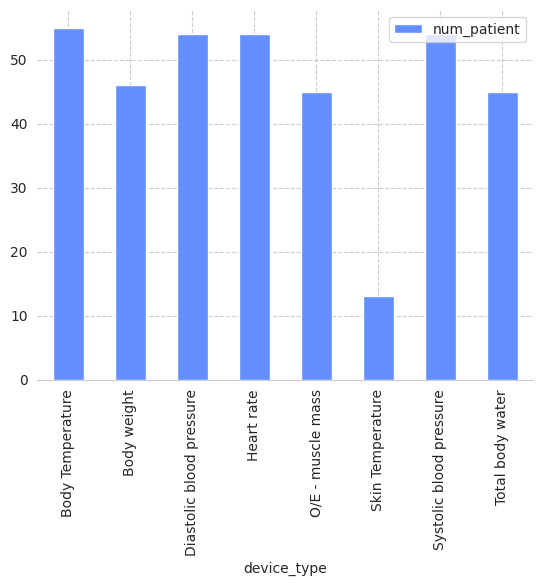

In [20]:
def count_patient(x):
  return x.nunique()
physio_df = data_dict['Physiology']
physio_df.groupby('device_type').agg(num_patient=('patient_id',count_patient)).plot.bar()

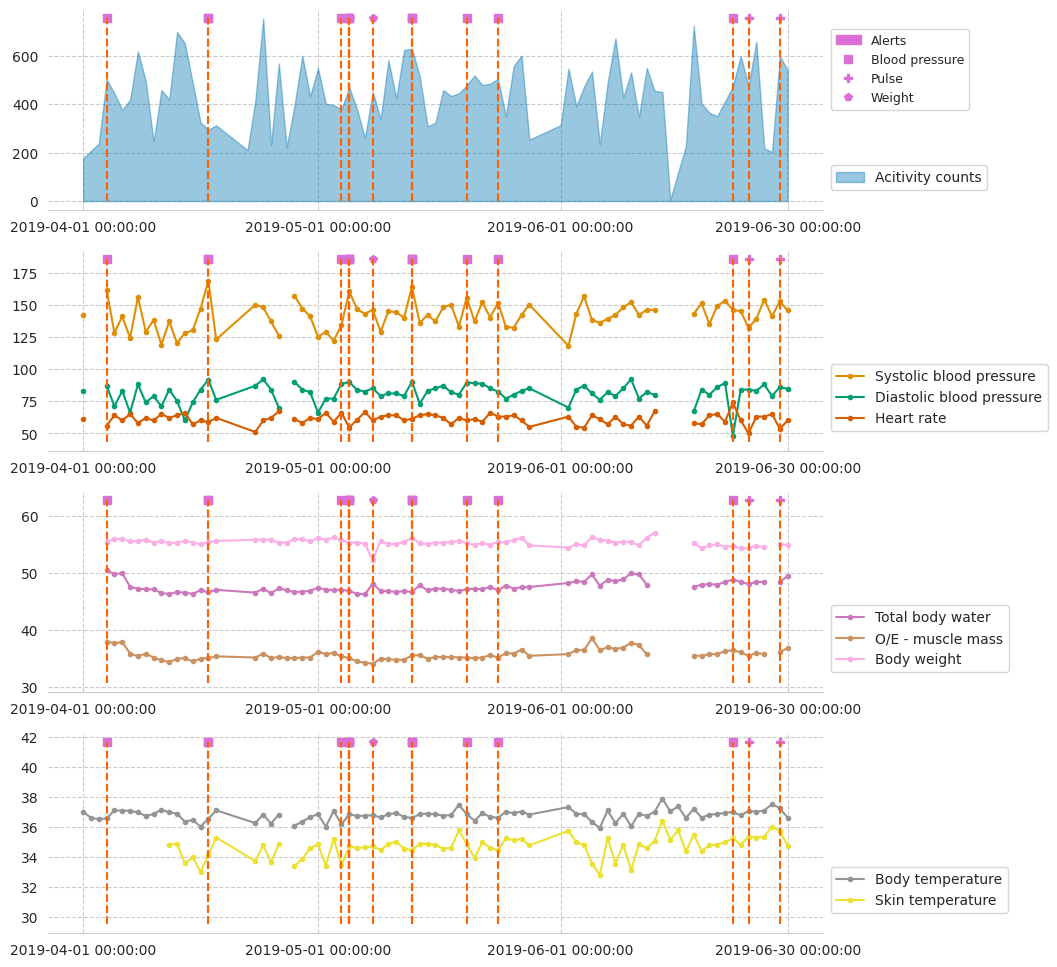

In [16]:
## Visualize Physiology measurements align with labels for an individual participant
pgrps = {'pgrp1': ['Systolic blood pressure','Diastolic blood pressure', 'Heart rate'],
            'pgrp2' : ['O/E - muscle mass', 'Total body water', 'Body weight'],
            'pgrp3' : [ 'Skin temperature','Body temperature']}
numerical_cols = data_dict['Physiology'].select_dtypes(include=[np.number]).columns
phys = data_dict['Physiology'].groupby(['patient_id','date','device_type'])[numerical_cols].agg('max')
phys.drop(phys.loc[phys.sum(axis=1)==0].index,axis=0,inplace=True)
phys.reset_index(inplace=True)
x_idx = phys.groupby('date')[phys.select_dtypes(include=['number']).columns].mean().index


vis_personal_aligned_multiview_day_plot(sleep_df=None,
                                        act_df=data_dict['Activity'],
                                        phys_df=data_dict['Physiology'],
                                        pgrps=pgrps,
                                        pid='c55f8',
                                        save_path=SAVE_PATH,
                                        labels_df=data_dict['Labels'],
                                        ftype='pdf',xticks=x_idx[[0,30,61,90]])

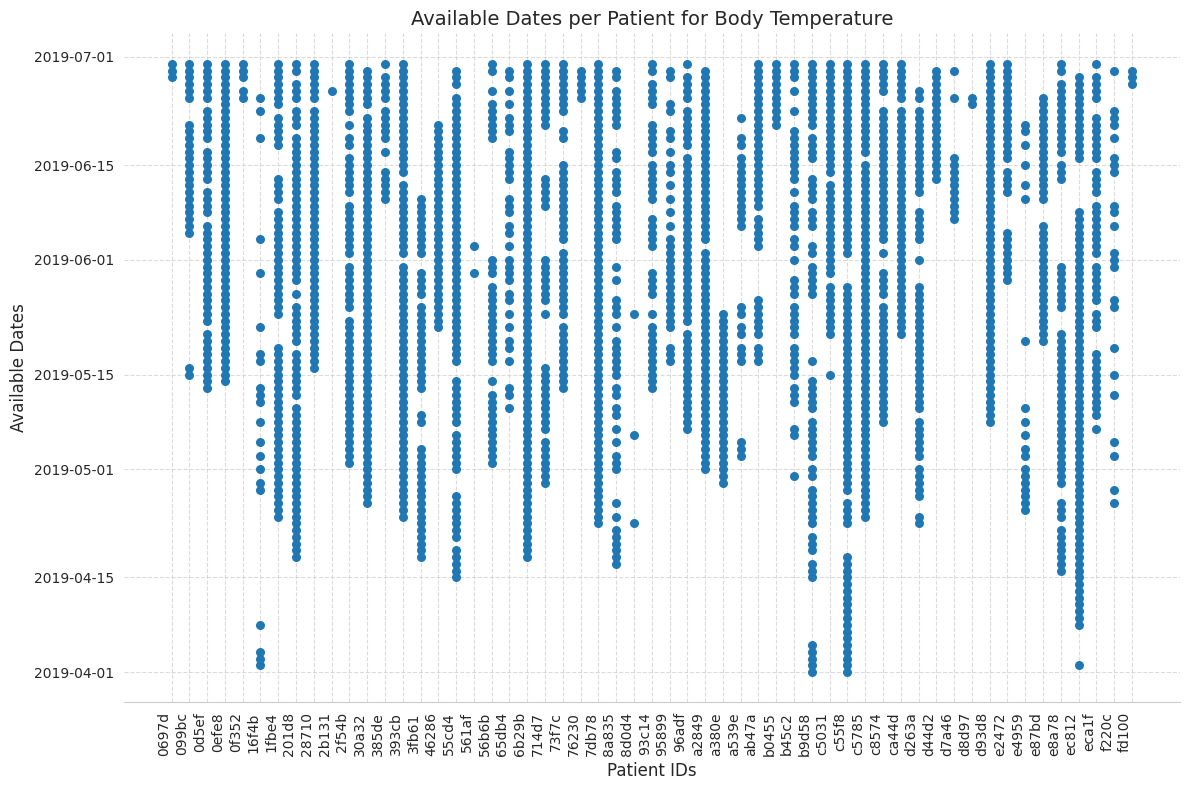

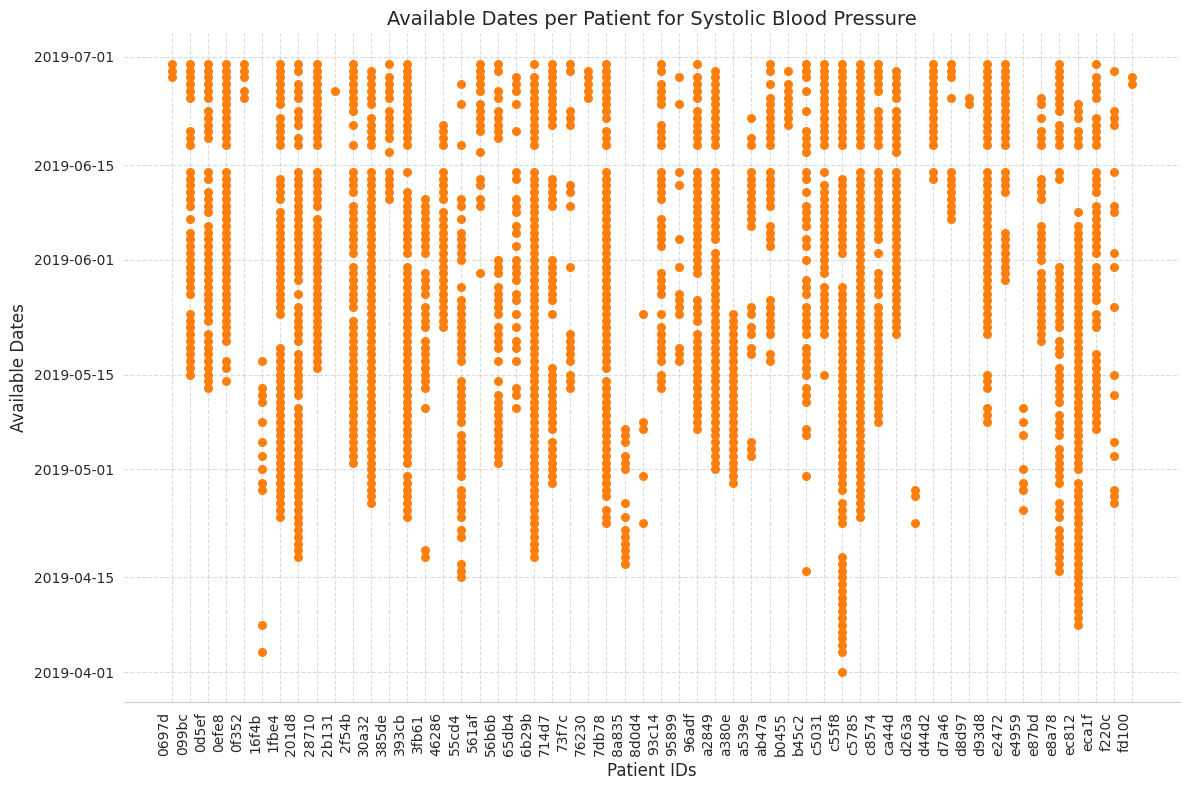

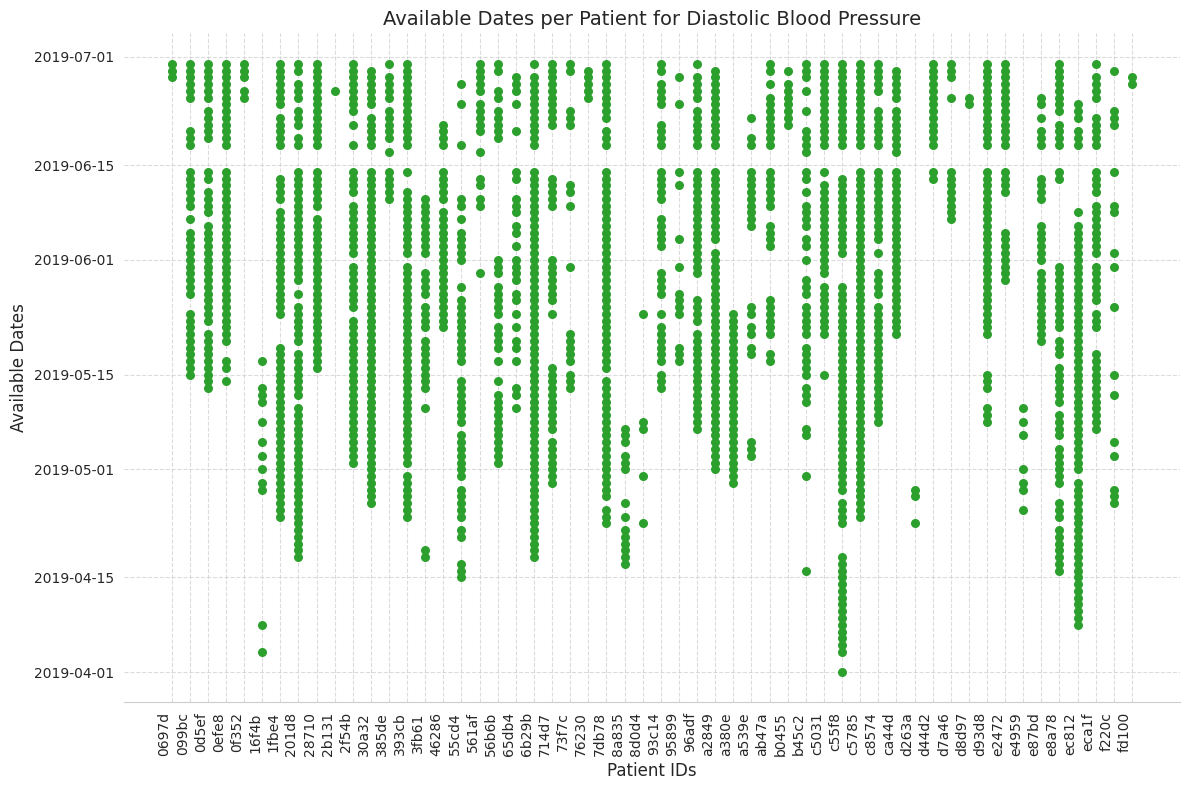

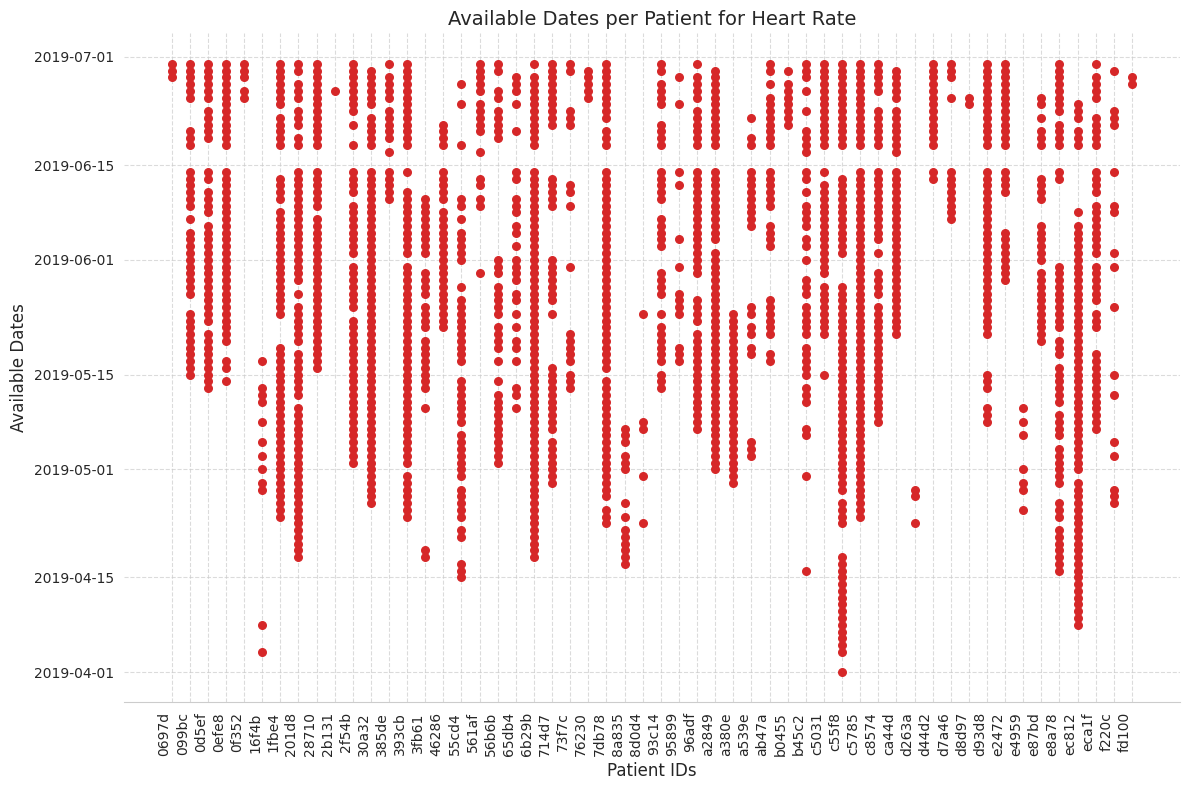

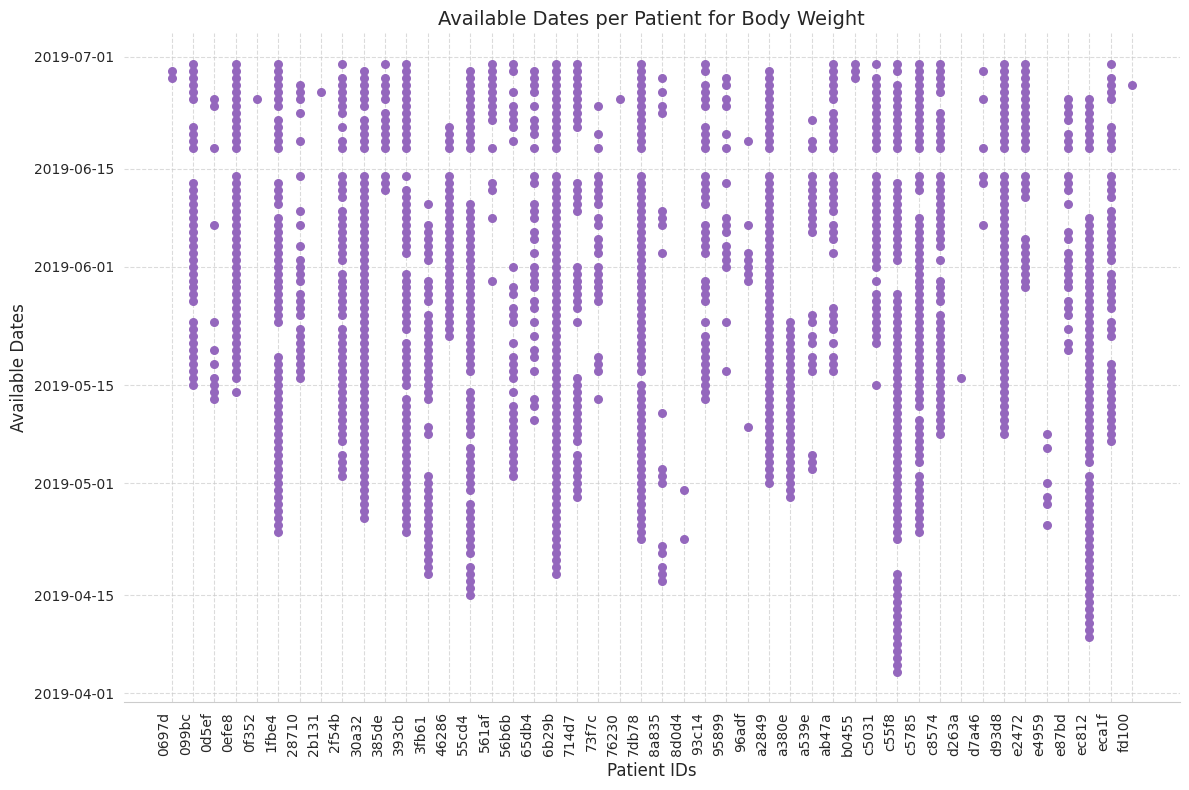

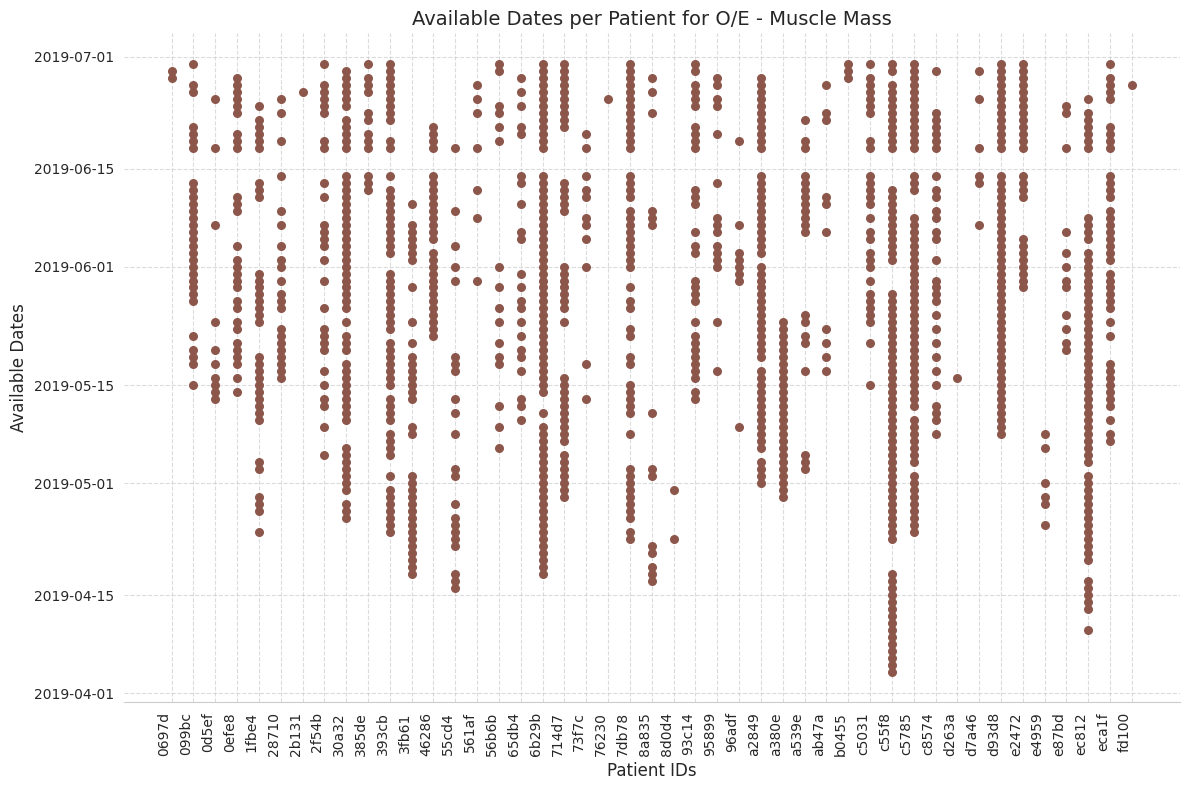

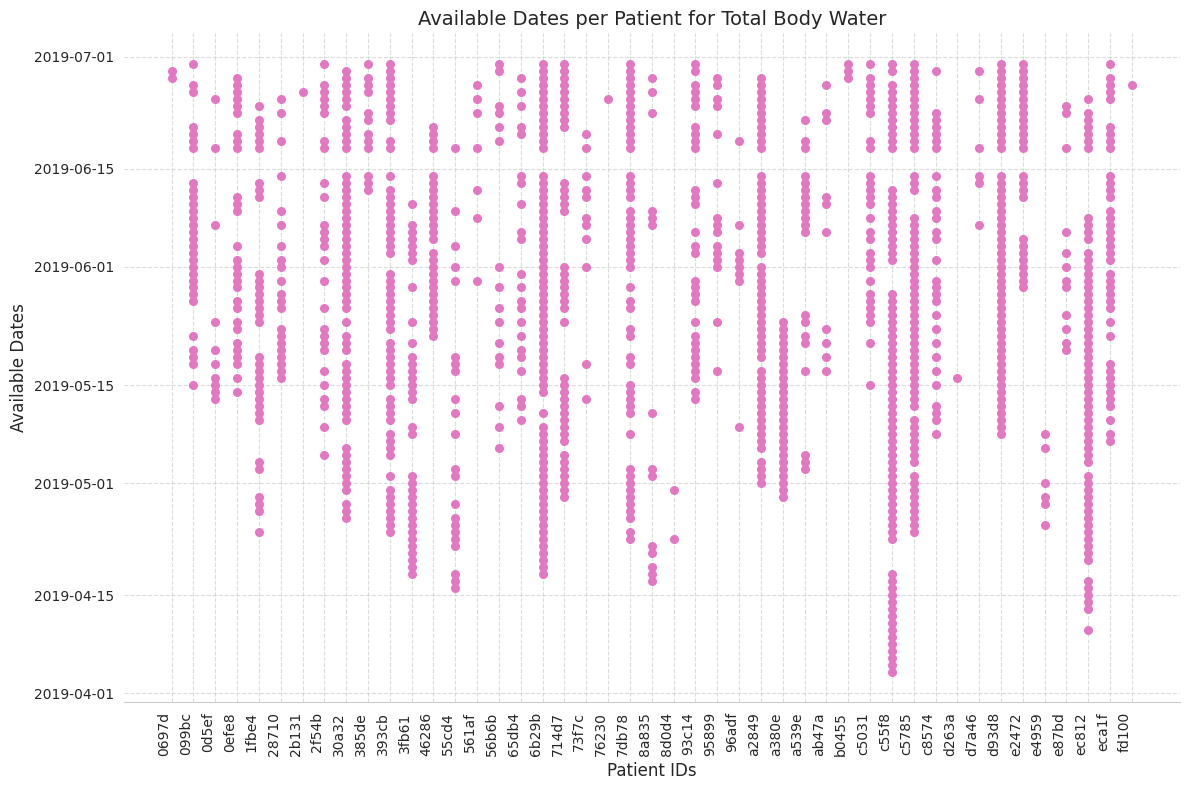

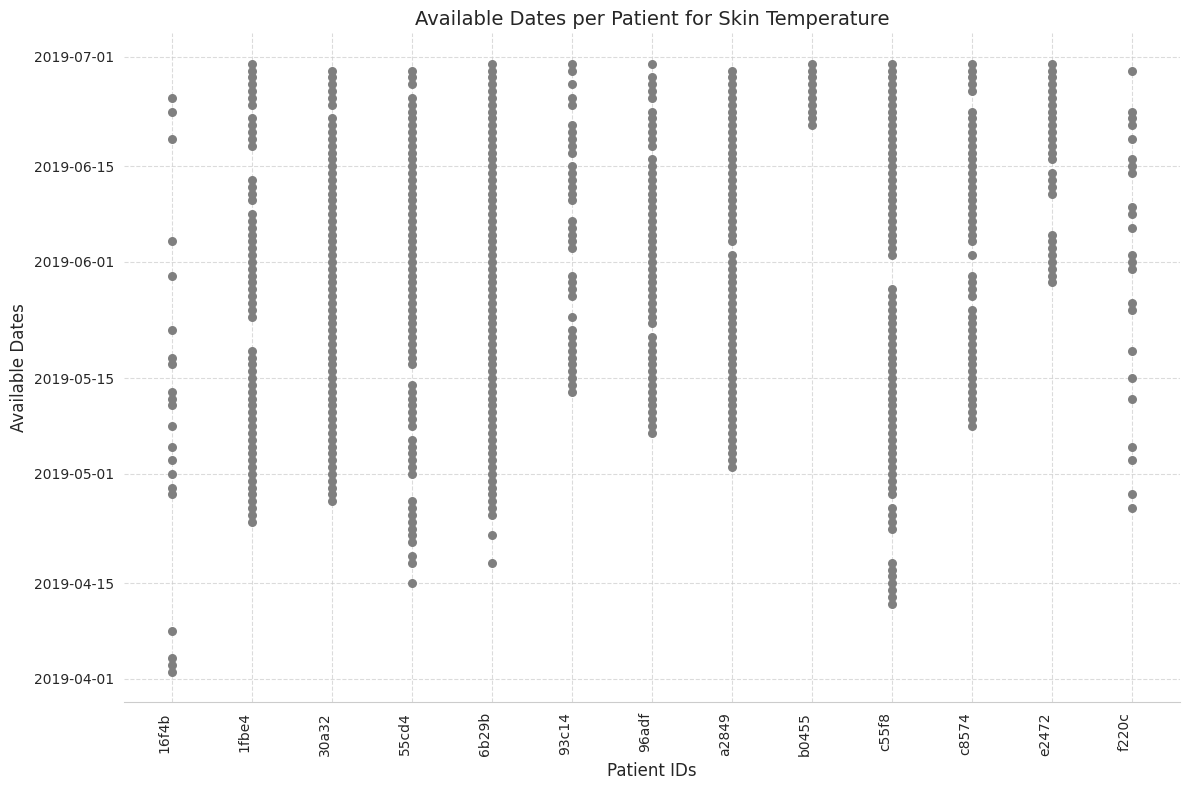

In [21]:
import pandas as pd

avai_dates = {}
patients = data_dict['Physiology'].patient_id.unique()
for pid in patients:

  # Assuming 'data_dict' and 'get_personal_df' are defined earlier
  df = get_personal_df(data_dict['Physiology'],pid).copy()
  #print(df.date)
  date_min = df.date.min()
  date_max = df.date.max()
  #print(f'{pid} min {date_min}')
  #print(f'max{date_max}')
  date_range = pd.date_range(start=date_min,end=date_max,freq='1D')
  avai_dates_p = {}
  for d in df.device_type.unique():
    date_device = df.loc[df['device_type']==d].date.unique()
    avai_dates_p[d] = date_device.tolist()  # Available dates
  avai_dates[pid] = avai_dates_p

# Create the plot figure

devices = data_dict['Physiology'].device_type.unique()  # Unique device types
colors = plt.cm.tab10.colors  # A colormap for assigning colors

# Loop through each device type
for i, d in enumerate(devices):

    fig, ax = plt.subplots(figsize=(12, 8))  # Increase figure size for better visualization

    data = {}
    for pid in patients:
        if d in avai_dates[pid].keys():
            data[pid] = avai_dates[pid][d]  # Collect avai dates for each patient-device pair

    # Prepare data for plotting
    patient_ids = list(data.keys())
    avai_dates_list = [avai_dates[pid][d] for pid in patient_ids]  # List of missed dates for each patient

    # Flatten the list of avai dates to plot each date individually
    all_patient_ids = []
    all_avai_dates = []

    for pid, avai_dates_for_pid in zip(patient_ids, avai_dates_list):
        all_patient_ids.extend([pid] * len(avai_dates_for_pid))  # Repeat patient ID for each missed date
        all_avai_dates.extend(avai_dates_for_pid)  # Flatten avai dates

    # Scatter plot for the current device
    ax.scatter(
        all_patient_ids,
        all_avai_dates,
        color=colors[i % len(colors)],
        label=d,
        s=30  # Adjust point size for better visibility
    )

    # Set axis labels and title
    ax.set_xlabel('Patient IDs', fontsize=12)
    ax.set_ylabel('Available Dates', fontsize=12)
    ax.set_title(f'Available Dates per Patient for {d.title()}', fontsize=14)

    # Rotate x-axis labels for better visibility
    plt.xticks(rotation=90, ha='right')

    # Display grid and adjust layout
    ax.grid(True, which='both', linestyle='--', alpha=0.7)
    plt.tight_layout()
    if d == 'O/E - muscle mass':
      d = 'muscle mass'
    plt.savefig(f'{SAVE_PATH}{d}.png')
    plt.show()


**Duplicated Values based on Timestamps**

In [63]:
patients = data_dict['Sleep'].patient_id.unique()
pid = patients[0]
sleep_df = get_personal_df(data_dict['Sleep'],pid).copy().reset_index().drop(['index','date'],axis=1)
activity_df = get_personal_df(data_dict['Activity'],pid).copy().reset_index().drop(['index','date'],axis=1)

In [87]:
data_dict['Activity'].loc[data_dict['Activity'].duplicated(['patient_id','location_name'])]

,patient_id,location_name,timestamp,date
4,0697d,Fridge Door,2019-06-28 13:14:09,2019-06-28
6,0697d,Back Door,2019-06-28 13:15:01,2019-06-28
7,0697d,Fridge Door,2019-06-28 13:15:01,2019-06-28
8,0697d,Front Door,2019-06-28 13:15:01,2019-06-28
9,0697d,Back Door,2019-06-28 13:15:02,2019-06-28
...,...,...,...,...
1030554,fd100,Hallway,2019-06-30 23:48:50,2019-06-30
1030555,fd100,Lounge,2019-06-30 23:49:40,2019-06-30
1030556,fd100,Kitchen,2019-06-30 23:50:02,2019-06-30
1030557,fd100,Front Door,2019-06-30 23:51:28,2019-06-30


In [88]:
patient_num = {}
for k,df in data_dict.items():

    patient_num[k] = df.patient_id.nunique()


[Text(0, 0, '56'),
 Text(0, 0, '17'),
 Text(0, 0, '49'),
 Text(0, 0, '56'),
 Text(0, 0, '55')]

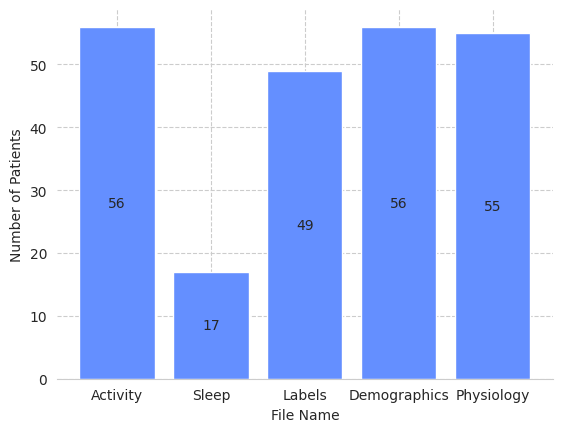

In [100]:
p=plt.bar(patient_num.keys(),patient_num.values())
plt.ylabel('Number of Patients')
plt.xlabel('File Name')
plt.bar_label(p,label_type='center')

In [ ]:
merged_df.loc[(~merged_df['state'].isna()) & (~merged_df['location_name'].isna()) & (merged_df['location_name']!='Bedroom')]

,patient_id,state,heart_rate,respiratory_rate,snoring,date_x,location_name,date_y
timestamp,,,,,,,,
2019-04-04 18:16:00,c55f8,LIGHT,59.0,17.0,False,2019-04-04,Kitchen,2019-04-04
2019-04-04 23:46:00,c55f8,DEEP,57.0,14.0,False,2019-04-04,Front Door,2019-04-04
2019-04-10 00:56:00,c55f8,LIGHT,59.0,17.0,False,2019-04-10,Front Door,2019-04-10
2019-04-10 08:00:00,c55f8,LIGHT,52.0,16.0,False,2019-04-10,Kitchen,2019-04-10
2019-04-10 21:58:00,c55f8,DEEP,56.0,15.0,False,2019-04-10,Kitchen,2019-04-10
2019-04-13 22:01:00,c55f8,AWAKE,63.0,17.0,False,2019-04-13,Fridge Door,2019-04-13
2019-04-13 22:24:00,c55f8,LIGHT,62.0,15.0,False,2019-04-13,Kitchen,2019-04-13
2019-04-14 08:17:00,c55f8,LIGHT,65.0,15.0,False,2019-04-14,Back Door,2019-04-14
2019-04-14 22:02:00,c55f8,AWAKE,50.0,13.0,False,2019-04-14,Kitchen,2019-04-14


In [226]:
physio_df = data_dict['Physiology'].copy()
label_df = data_dict['Labels'].copy()

In [227]:
physio_label_df = pd.merge(physio_df,label_df,on=['timestamp','date','patient_id'],how='outer')

In [228]:
physio_label_df = physio_label_df.sort_values(['patient_id','timestamp'])


In [230]:
physio_label_df

,patient_id,timestamp,device_type,value,unit,date,type
17571,0697d,2019-06-28 13:30:43,NaN,NaN,NaN,2019-06-28,Blood pressure
17572,0697d,2019-06-28 13:30:43,NaN,NaN,NaN,2019-06-28,Pulse
17574,0697d,2019-06-28 13:42:09,Body Temperature,36.072,Cel,2019-06-28,NaN
17575,0697d,2019-06-28 13:42:44,Body Temperature,35.831,Cel,2019-06-28,NaN
17576,0697d,2019-06-28 13:43:40,Body Temperature,35.831,Cel,2019-06-28,NaN
...,...,...,...,...,...,...,...
17651,fd100,2019-06-28 21:09:27,Heart rate,61.000,beats/min,2019-06-28,NaN
17652,fd100,2019-06-28 21:32:19,Body Temperature,36.879,Cel,2019-06-28,NaN
17653,fd100,2019-06-28 21:32:46,Body Temperature,36.879,Cel,2019-06-28,NaN
17982,fd100,2019-06-29 21:05:11,Body Temperature,36.240,Cel,2019-06-29,NaN


In [164]:
blood_pressure_dates = physio_label_df.loc[physio_label_df['type']=='Blood pressure'].date.unique()
df = pd.pivot_table(physio_label_df,values='value',columns='device_type',index='timestamp')[['Systolic blood pressure','Diastolic blood pressure']].copy()
df.loc[~df.isna().apply(lambda x: all(x), axis=1)]
df['Pressure Difference'] = df['Systolic blood pressure'] - df['Diastolic blood pressure']
df[~df.isna().apply(lambda x: all(x), axis=1)]

device_type,Systolic blood pressure,Diastolic blood pressure,Pressure Difference
timestamp,,,
2019-04-01 08:57:31,142.0,83.0,59.0
2019-04-04 09:50:12,174.0,99.0,75.0
2019-04-04 10:35:53,149.0,75.0,74.0
2019-04-04 17:02:31,152.0,80.0,72.0
2019-04-05 10:35:20,128.0,71.0,57.0
...,...,...,...
2019-06-30 22:44:56,187.0,89.0,98.0
2019-06-30 22:46:34,180.0,93.0,87.0
2019-06-30 22:48:01,181.0,92.0,89.0


In [165]:
physio_label_df.loc[physio_label_df['type']=='Agitation']

,patient_id,timestamp,device_type,value,unit,date,type
12753,099bc,2019-06-10 12:01:04,NaN,NaN,NaN,2019-06-10,Agitation
8873,0cda9,2019-05-28 12:01:04,NaN,NaN,NaN,2019-05-28,Agitation
7446,0d5ef,2019-05-23 12:01:46,NaN,NaN,NaN,2019-05-23,Agitation
7777,0d5ef,2019-05-24 12:02:08,NaN,NaN,NaN,2019-05-24,Agitation
8031,0d5ef,2019-05-25 12:01:29,NaN,NaN,NaN,2019-05-25,Agitation
...,...,...,...,...,...,...,...
3009,ec812,2019-05-06 12:00:43,NaN,NaN,NaN,2019-05-06,Agitation
4116,ec812,2019-05-11 12:01:19,NaN,NaN,NaN,2019-05-11,Agitation
11965,ec812,2019-06-07 18:01:26,NaN,NaN,NaN,2019-06-07,Agitation
12676,ec812,2019-06-10 09:50:00,NaN,NaN,NaN,2019-06-10,Agitation


In [170]:
from datetime import timedelta
pid = '099bc'
date = pd.to_datetime('2019-06-10')
df_p = get_personal_df(physio_label_df,pid)
df_filtered = df_p.loc[df_p['date'].isin([date-timedelta(days=2),
                                       date-timedelta(days=1),date])]
df_filtered

,timestamp,device_type,value,unit,date,type
12038,2019-06-08 08:38:20,Body Temperature,36.871,Cel,2019-06-08,NaN
12039,2019-06-08 08:38:52,Body Temperature,36.966,Cel,2019-06-08,NaN
12040,2019-06-08 08:39:05,Body Temperature,36.096,Cel,2019-06-08,NaN
12044,2019-06-08 08:39:20,Body Temperature,36.966,Cel,2019-06-08,NaN
12048,2019-06-08 08:42:34,Body weight,52.400,kg,2019-06-08,NaN
12049,2019-06-08 08:42:34,Total body water,52.300,%,2019-06-08,NaN
12050,2019-06-08 08:42:34,O/E - muscle mass,37.400,kg,2019-06-08,NaN
12306,2019-06-09 08:22:48,Systolic blood pressure,142.000,mm[Hg],2019-06-09,NaN
12307,2019-06-09 08:22:48,Diastolic blood pressure,80.000,mm[Hg],2019-06-09,NaN
12308,2019-06-09 08:22:48,Heart rate,79.000,beats/min,2019-06-09,NaN


Agitation Plot

In [27]:
ag_patients = ['099bc', '0cda9', '0d5ef']
pid = ag_patients[2]
activity_df = get_personal_df(data_dict['Activity'].copy(),pid)
physio_df = get_personal_df(data_dict['Physiology'].copy(),pid)
label_df = get_personal_df(data_dict['Labels'].copy(),pid)
ph_df = pd.pivot_table(physio_df,values='value',columns='device_type',index=['timestamp','date']).reset_index()
label_df['Agitation'] = label_df['type'].copy().apply(lambda x: 1 if x=='Agitation' else 0)
merge_df = pd.merge(ph_df,activity_df,on=['timestamp','date'],how='outer')
merge_df = pd.merge(merge_df,label_df,on=['timestamp','date'],how='outer')

In [76]:
ag_date = pd.to_datetime(merge_df.loc[merge_df['Agitation']==1].timestamp.values[0])

In [85]:
from datetime import timedelta
#dates = [ag_date-timedelta(days=1),ag_date]
# Create the time range (subtract 10 hours and include ag_date)
start_time = ag_date - timedelta(hours=24)
end_time = ag_date + timedelta(hours=1)

# Filter merge_df based on the timestamp range
df = merge_df.loc[merge_df['timestamp'].between(start_time, end_time)]

In [81]:
df

,timestamp,date,Body Temperature,Body weight,Diastolic blood pressure,Heart rate,O/E - muscle mass,Systolic blood pressure,Total body water,location_name,type,Agitation
4281,2019-05-23 07:25:44,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Lounge,NaN,NaN
4282,2019-05-23 07:26:11,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kitchen,NaN,NaN
4283,2019-05-23 07:26:12,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hallway,NaN,NaN
4284,2019-05-23 07:27:27,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kitchen,NaN,NaN
4285,2019-05-23 07:27:54,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hallway,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
4511,2019-05-23 12:47:14,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fridge Door,NaN,NaN
4512,2019-05-23 12:47:32,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fridge Door,NaN,NaN
4513,2019-05-23 12:48:26,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Kitchen,NaN,NaN
4514,2019-05-23 12:49:22,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Hallway,NaN,NaN


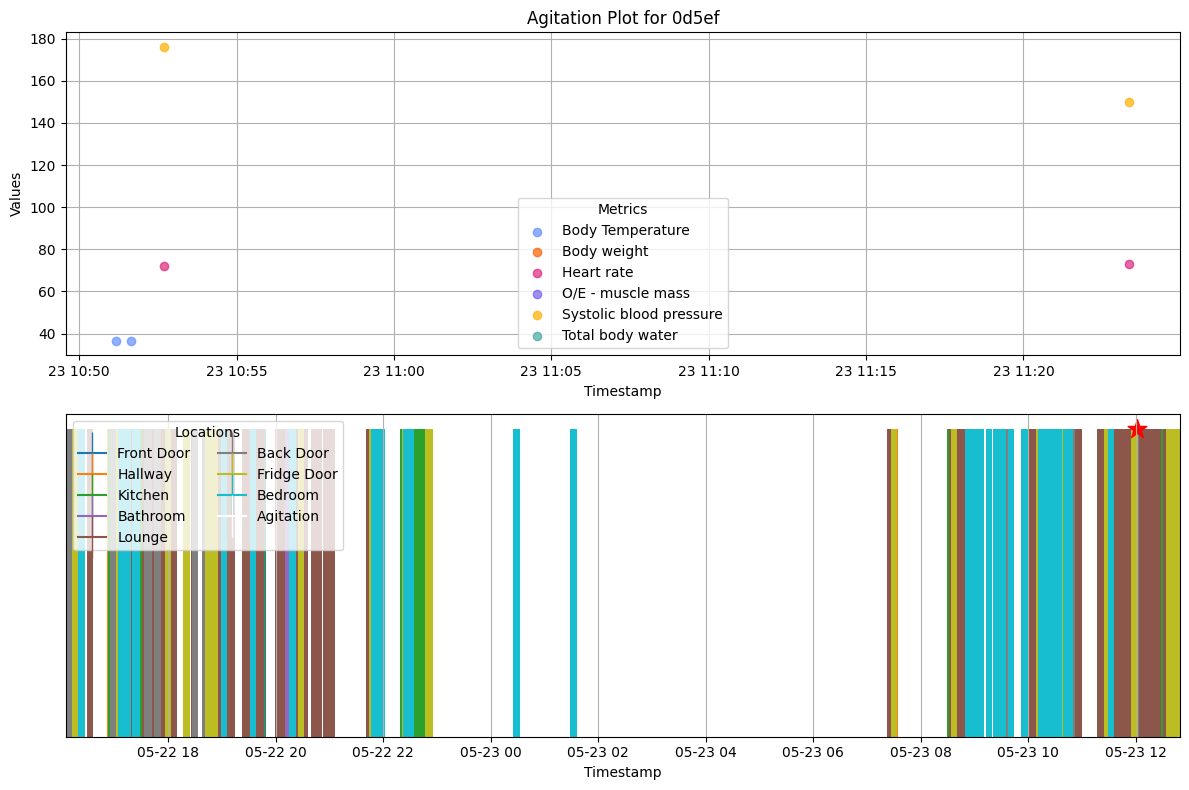

In [87]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# Remove rows where 'location_name' is NaN
df_clean = df.dropna(subset=['location_name'])

# Plot
fig, axs = plt.subplots(2, 1, figsize=(12, 8))

# First plot (as before)
Y = ['Body Temperature', 'Body weight', 'Heart rate',
     'O/E - muscle mass', 'Systolic blood pressure', 'Total body water']
for y_col in Y:
    axs[0].scatter(df['timestamp'], df[y_col], label=y_col, alpha=0.7)
axs[0].set_xlabel('Timestamp')
axs[0].set_ylabel('Values')
axs[0].set_title(f'Agitation Plot for {pid}')
axs[0].grid(True)
axs[0].legend(loc='best', title='Metrics')

# Second plot: Timeline with location names and different colors
# Create a colormap and assign a color to each unique location
unique_locations = df_clean['location_name'].unique()
colors = plt.cm.get_cmap('tab10', len(unique_locations))  # You can change 'tab10' to another colormap

# Create a list to store the legend handles and labels
legend_handles = []
legend_labels = []

# Plot each location with a colored bar
for idx, l in enumerate(unique_locations):
    if not pd.isna(l):  # Check if location name is not NaN
        location_data = df_clean[df_clean['location_name'] == l]
        # Create vertical bars for each location along the timestamp
        for timestamp in location_data['timestamp']:
            # Plot the bar for each timestamp
            axs[1].bar(timestamp, 1, width=0.005, color=colors(idx), align='center')

        # Add a dummy artist to the legend manually for each location
        legend_handles.append(plt.Line2D([0], [0], marker='|', color=colors(idx), markerfacecolor=colors(idx), markersize=15))  # Increased markersize
        legend_labels.append(l)

# Plot agitation points as vertical bars (like poles or bars)
agitation_df = df.loc[df['Agitation'] == 1].copy()
for timestamp in agitation_df['timestamp']:
    axs[1].scatter(timestamp,1,marker='*', color='r', s=200)  # Vertical bar-like line

# Manually add agitation to the legend
legend_handles.append(plt.Line2D([0], [0], marker='|', color='w', markerfacecolor='r', markersize=15))  # Increased markersize
legend_labels.append('Agitation')

# Add the legend manually using the handles and labels
axs[1].legend(legend_handles, legend_labels, loc='upper left', title='Locations', ncol=2, markerscale=2)

axs[1].set_xlabel('Timestamp')
axs[1].set_yticks([])  # Remove y-ticks
#axs[1].set_title('Timeline of Locations Over Time')
axs[1].set_xlim(df_clean['timestamp'].min(), df_clean['timestamp'].max())  # Set x-axis limits
axs[1].grid(True)

# Adjust layout to make space for the legend
plt.tight_layout()
#plt.title(f'Agitation Plot for {pid}')
plt.show()


In [124]:
unique_locations

['Lounge', 'Hallway', 'Kitchen', 'Fridge Door', 'Front Door', 'Bathroom', 'Bedroom', 'Back Door', NaN]
Categories (8, object): ['Back Door', 'Bathroom', 'Bedroom', 'Fridge Door', 'Front Door', 'Hallway',
                         'Kitchen', 'Lounge']

In [36]:
agitation_df

,timestamp,date,Body Temperature,Body weight,Diastolic blood pressure,Heart rate,O/E - muscle mass,Systolic blood pressure,Total body water,location_name,type,Agitation
4461,2019-05-23 12:01:46,2019-05-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Agitation,1.0


In [38]:
ag_date

numpy.datetime64('2019-05-23T00:00:00.000000000')